# CEF Fit to $\rm K Er Se_2$

We loop through a series of $B_2^0$ values, re-fit the CEF Hamiltonian for each value, and then find a "Best-fit line" through parameter space as a function of $B_2^0$. We then truncate this line at the points where reduced $\chi^2$ increases by 1 over the global minimum, and use that to estimate uncertainty in the final calculated values.

Allen Scheie, December 2019

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator
import sys

import PyCrystalField as cef

In [2]:
data1p6K = np.genfromtxt('KES_CEF_data/cuts_ei9mev_1p6K.txt', unpack=True)
data15K = np.genfromtxt('KES_CEF_data/cuts_ei9mev_15K.txt', unpack=True)
data100K = np.genfromtxt('KES_CEF_data/cuts_ei9mev_100K.txt', unpack=True)

alldata = [data1p6K,data15K,data100K]
datatemps = [1.8, 15, 100]

<IPython.core.display.Javascript object>


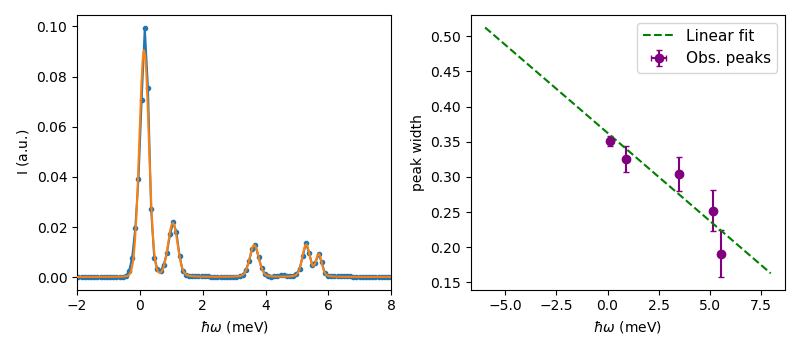

[0.13515156487106053, 0.9132071732842264, 3.504800645878369, 5.155917342976868, 5.560145541287389] [0.3512410705480638, 0.3253514112153624, 0.3043522834245795, 0.25200588513890115, 0.1910902208311937] 0.061315245063475
[-0.0249575   0.36262711]


In [3]:
## Pick out observed eigenvalues
from scipy.special import wofz


def gaus(x, a, x0, sig):
    return a/(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - x0)/sig, 2.)/2.)

def voigt(x, a, x0, alpha, gamma):
    """ Return the Voigt line shape at x with Lorentzian component FWHM gamma
    and Gaussian component FWHM alpha."""
    sigma = (0.5*alpha) / np.sqrt(2 * np.log(2))
    return a*np.real(wofz(((x-x0) + 1j*(0.5*gamma))/sigma/np.sqrt(2))) / sigma\
                                                        /np.sqrt(2*np.pi)

dx, dy, de = alldata[0][0], alldata[0][1], alldata[0][2]

def gausfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4):
    return gaus(x-x0, a0,0,w0) + gaus(x-x0, a1,x1,w1) + gaus(x-x0, a2,x2,w2) +\
            gaus(x-x0, a3,x3,w3) + gaus(x-x0, a4,x4,w4) + 0.00015

LW = 0.1
def voigtfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4, lw0, lw):
    return voigt(x-x0, a0,0,w0, lw0) + voigt(x-x0, a1,x1,w1, lw) + voigt(x-x0, a2,x2,w2, lw) +\
            voigt(x-x0, a3,x3,w3, lw) + voigt(x-x0, a4,x4,w4, lw) + 0.00015

p0 = [4e-2, 0.15,0.25, 9e-3,0.87,0.25, 5e-3,3.47,0.25, 5e-3,5.11,0.18, 4e-3,5.58,0.18, 0.1, 0.1]

poptinitial, pcovinitial = curve_fit(voigtfitfun, dx, dy, sigma=de, p0=p0)
uncinitial = np.sqrt(np.diag(pcovinitial))

f, ax = plt.subplots(1,2, figsize=(8,3.5))

ax[0].errorbar(dx,dy,de, marker='.')
xxx = np.linspace(-2,10,300)
# ax[0].plot(xxx, voigtfitfun(xxx, *p0), zorder=10)
ax[0].plot(xxx, voigtfitfun(xxx, *poptinitial), zorder=10)
ax[0].set_xlim(-2,8)
ax[0].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].set_ylabel('$\\rm I$ (a.u.)')

#### 
ObsEnergies, DOE = [poptinitial[3*i+1] for i in range(0,5)],  [uncinitial[3*i+1] for i in range(0,5)], 
ObsWidths, DOW = [poptinitial[3*i+2] for i in range(0,5)],    [uncinitial[3*i+2] for i in range(0,5)]
print(ObsEnergies, ObsWidths, poptinitial[-1])
fittedLW = poptinitial[-1]

ax[1].errorbar(ObsEnergies, ObsWidths, xerr = DOE, yerr = DOW, capsize=2, marker='o', 
               ls='none', color='purple', label='Obs. peaks')
def straightline(x,a,b):
    return a*x + b
# width_popt, width_pcov = curve_fit(straightline, ObsEnergies, ObsWidths, sigma=DOW, p0=[-0.008,0.16])
width_popt, width_pcov = curve_fit(straightline, ObsEnergies[1:], ObsWidths[1:],  p0=[-0.008,0.16])
xxx = np.linspace(-6,8,3)
ax[1].plot(xxx, straightline(xxx, *width_popt), color='green', ls='--', label='Linear fit')
ax[1].set_xlabel("$\\hbar \\omega$ (meV)")
ax[1].set_ylabel("peak width")
ax[1].legend(fontsize=11)

plt.tight_layout()

print(width_popt)

#### A note on the resolution functions
Inexplicably, the fit converges much better when I use my straight line fit to the peak widths as a resolution function than when I use Ovi's calculated resolution function. I don't know why this is, but the thing about fitting is that it doesn't matter how you get to the minimum as long as you got there.

<IPython.core.display.Javascript object>


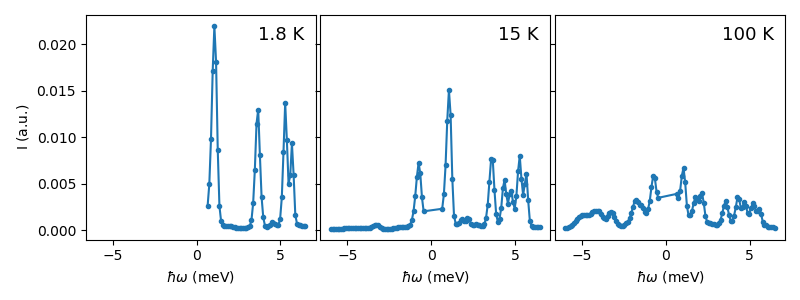

In [4]:
## Black out the elastic line, because it includes extra contributions from incoherent scattering, background, etc.
from copy import deepcopy

fitdata = deepcopy(alldata)

# fitdata[0][:,:100] *= np.nan
for i in range(len(fitdata)):
    fitdata[i] = np.hstack((fitdata[i][:,40:96], fitdata[i][:,106:-15]))
    
fitdata[0] = fitdata[0][:,56:]
    
f, ax = plt.subplots(1,3, figsize=(8,3), sharex=True, sharey=True)
for i,data in enumerate(fitdata):
    ax[i].errorbar(data[0], data[1], data[2], marker='.')
    ax[i].text(0.95,0.95, str(datatemps[i])+' K', transform=ax[i].transAxes,
              verticalalignment='top', horizontalalignment='right', fontsize=13)
    ax[i].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].set_ylabel('$\\rm I$ (a.u.)')
    
plt.tight_layout()
f.subplots_adjust(wspace=0.02)

In [5]:
FitCoefRes1a, FitCoefRes2a = np.load('KES_bestfitcoeff.npy', allow_pickle=True)

## Define global Chi2

In [6]:
# Build Hamiltonian, ignoring the negative stevens operators (because they shouldn't be allowed by symmetry).
ion = 'Er3+'
ionJ = cef.Jion[ion][2]


Er_O = []
for n in range(2,8,2):
    for m in range(0,n+1,3):
        if   n == 6: i = 8 + m
        elif n == 4: i = 3 + m
        elif n == 2: i = m
        Er_O.append(  cef.StevensOp(ionJ,n,m)  )

        
Er = cef.CFLevels(Er_O, FitCoefRes1a['coeff'])
Er.diagonalize()

######################

xoffset = ObsEnergies[0]+0.02
ObservedEnergies = [0]+ObsEnergies[1:]+[np.nan,np.nan, np.nan]

def err_global_final(CFLevelsObject, coeff, gammas, xoff, pref, bkg, thermexp):
    """Global error to all functions passed to it, used for fitting"""
    # define new Hamiltonian
    newH = np.sum([a*b for a,b in zip(CFLevelsObject.O, coeff)], axis=0)
    CFLevelsObject.diagonalize(newH)

    erro = 0

    # Compute error in neutron spectrum
    for i,data in enumerate(fitdata):
        errspec = (pref* CFLevelsObject.normalizedNeutronSpectrum(Earray=data[0]*(1+datatemps[i]*thermexp)-xoff,
                                                                  Temp=datatemps[i],
                                    ResFunc= lambda de: straightline(de, *width_popt), gamma=gammas[i]) )+\
                        bkg[i] -data[1]
                
        erro += np.nansum((errspec/data[2])**2)
        
    sys.stdout.write("\r err = "+str(erro)+'    ')
    sys.stdout.flush() # important for printing progress
    return erro

err_global_final(Er, coeff = FitCoefRes1a['coeff'], gammas=FitCoefRes1a['gammas'], 
                        pref=FitCoefRes1a['pref'], xoff = FitCoefRes1a['xoff'], bkg=FitCoefRes1a['bkg'], 
                          thermexp=FitCoefRes1a['thermexp'])

 err = 16710.614721427504    

16710.614721427504

# Now, loop through B20 values and find the best fit parameters and see how they hold up.

In [7]:
from scipy.optimize import minimize

B20_array = np.hstack((np.arange(1.0,0.8, -0.05) * FitCoefRes1a['coeff'][0],
                       (np.arange(0.8,1.2, 0.05) * FitCoefRes1a['coeff'][0])))
print(B20_array)

[-0.02760064 -0.02622061 -0.02484058 -0.02346055 -0.02208051 -0.02346055
 -0.02484058 -0.02622061 -0.02760064 -0.02898068 -0.03036071 -0.03174074]


In [8]:
BestFitCoeffLine = []
for i,B20 in enumerate(B20_array):
    print('\n',i,' ', B20)
    
    def linefitfunction(parameters):
        newparameters = np.hstack(([B20], parameters[1:6]))
        return err_global_final(CFLevelsObject= Er, coeff=newparameters, 
                        gammas=parameters[6:9], xoff = parameters[9], 
                                bkg=FitCoefRes1a['bkg'], 
                          thermexp=parameters[10], pref=parameters[0])
    
    startingcoeffA = np.hstack((FitCoefRes1a['pref'], FitCoefRes1a['coeff'][1:6],
                            FitCoefRes1a['gammas'], FitCoefRes1a['xoff'], FitCoefRes1a['thermexp']))
    if i == 0:
        FitCoefResLineA= minimize(linefitfunction, x0 = startingcoeffA,  method = 'Nelder-Mead')
        BestFitCoeffLine.append(FitCoefResLineA)
        FitCoefResLine = FitCoefResLineA
    else:
        startingcoeffB = np.hstack((FitCoefRes1a['pref'], FitCoefResLine.x[1:6],
                            FitCoefRes1a['gammas'], FitCoefRes1a['xoff'], FitCoefRes1a['thermexp']))
        
        FitCoefResLineA = minimize(linefitfunction, x0 = startingcoeffA,  method = 'Nelder-Mead')
        FitCoefResLineB = minimize(linefitfunction, x0 = startingcoeffB,  method = 'Nelder-Mead')
        if FitCoefResLineA.fun < FitCoefResLineB.fun:
            FitCoefResLine = FitCoefResLineA
            BestFitCoeffLine.append(FitCoefResLineA)
        else:
            FitCoefResLine = FitCoefResLineB
            BestFitCoeffLine.append(FitCoefResLineB)


 0   -0.027600642901855786
 err = 16710.586129155385    
 1   -0.026220610756762994
 err = 16802.4337557276      
 2   -0.024840578611670206
 err = 17075.070093154245    
 3   -0.023460546466577414
 err = 17535.497755491622    
 4   -0.02208051432148463
 err = 18161.824559591318    
 5   -0.02346054646657742
 err = 17528.4030804413      
 6   -0.02484057861167021
 err = 17097.599791855257    
 7   -0.026220610756763
 err = 16802.715038617447    
 8   -0.027600642901855793
 err = 16715.163398324083    
 9   -0.02898067504694858
 err = 16801.423293741653    
 10   -0.030360707192041373
 err = 17072.490054846487    
 11   -0.031740739337134165
 err = 17526.174099520373    

In [9]:
numfreeparams = len(np.hstack(([alldata[i][0] for i in range(len(alldata))])))

bestfitline = [np.hstack((BestFitCoeffLine[i].x[0], B20_array[i], 
                          BestFitCoeffLine[i].x[1:], BestFitCoeffLine[i].fun/numfreeparams)) 
               for i in range(len(BestFitCoeffLine))]
bestfitline = np.array(bestfitline).T

<IPython.core.display.Javascript object>


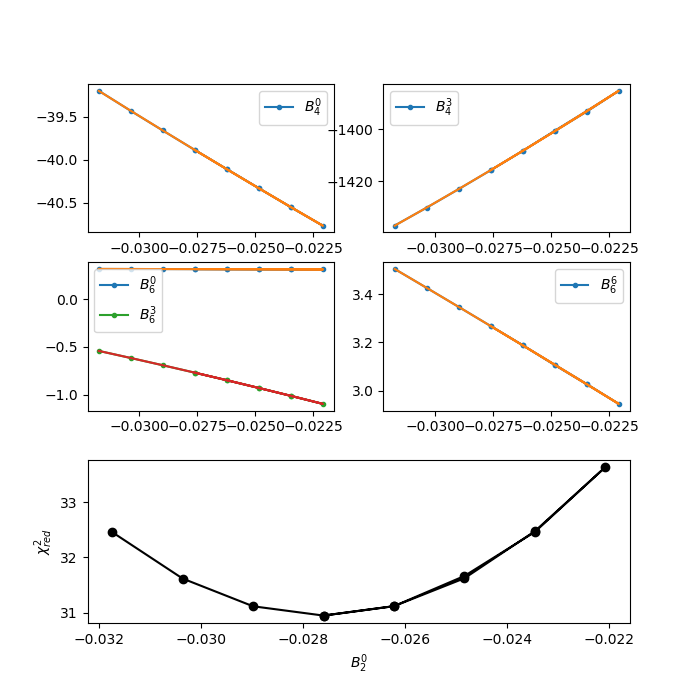

Text(0.5, 0, '$B_2^0$')

In [10]:
def curvedline(x,a,b, c):
    return a*x + b + c*x**2

ll=0
B40popt, B40pcov = curve_fit(curvedline, bestfitline[1][ll:], bestfitline[0+2][ll:])
B43popt, B43pcov = curve_fit(curvedline, bestfitline[1][ll:], bestfitline[1+2][ll:])
B60popt, B60pcov = curve_fit(curvedline, bestfitline[1][ll:], bestfitline[2+2][ll:])
B63popt, B63pcov = curve_fit(curvedline, bestfitline[1][ll:], bestfitline[3+2][ll:])
B66popt, B66pcov = curve_fit(curvedline, bestfitline[1][ll:], bestfitline[4+2][ll:])


def bestfitCoeff(B20):
    return [B20, straightline(B20, *B40popt), straightline(B20, *B43popt), 
            straightline(B20, *B60popt), straightline(B20, *B63popt), straightline(B20, *B66popt)]


##################### Plot 

fig = plt.figure(figsize=(7,7))
outer = gridspec.GridSpec(2,1, figure=fig, height_ratios=[2,1])
gs0 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer[0])

ax1 = [fig.add_subplot(gs0[i,j]) for i in range(2) for j in range(2)]
ax2 = fig.add_subplot(outer[1])

bfstyle = {'marker':'.'}
scale = 1e5
ax1[0].plot(bestfitline[1], bestfitline[0+2]*scale, **bfstyle, label='$B_4^0$')
ax1[0].plot(bestfitline[1], curvedline(bestfitline[1], *B40popt)*scale)

ax1[1].plot(bestfitline[1], bestfitline[1+2]*scale, **bfstyle, label='$B_4^3$')
ax1[1].plot(bestfitline[1], curvedline(bestfitline[1], *B43popt)*scale)

ax1[2].plot(bestfitline[1], bestfitline[2+2]*scale, **bfstyle, label='$B_6^0$')
ax1[2].plot(bestfitline[1], curvedline(bestfitline[1], *B60popt)*scale)

ax1[2].plot(bestfitline[1], bestfitline[3+2]*scale, **bfstyle, label='$B_6^3$')
ax1[2].plot(bestfitline[1], curvedline(bestfitline[1], *B63popt)*scale)

ax1[3].plot(bestfitline[1], bestfitline[4+2]*scale, **bfstyle, label='$B_6^6$')
ax1[3].plot(bestfitline[1], curvedline(bestfitline[1], *B66popt)*scale)
    
for i in range(4):
    ax1[i].legend()
    
chisqstyle = {'marker':'o'}

#ax2.plot(bestfitline[1], bestfitline[-1]/(len(alldata[0].cx)+len(alldata[1].cx)), color='k',  **chisqstyle)
ax2.plot(bestfitline[1], bestfitline[-1], color='k',  **chisqstyle)
ax2.set_ylabel('$\\chi^2_{red}$')
#ax2.set_ylim(0,)
ax2.set_xlabel('$B_2^0$')

In [11]:
np.save('KES_loopthrough_bestfitline', bestfitline)